In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pymysql

#  Step 1: Define the connection BEFORE try block
connection = pymysql.connect(
    host='localhost',
    user='root',       
    password='RAVI12345@',
    database='rfm_project'    
)

 

In [4]:
def call_proc(proc_name):
    cursor = connection.cursor()
    cursor.execute(f"CALL {proc_name}()")   #call procedure
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(result, columns=columns)
    cursor.close()
    return df


In [5]:
#3. call all procedures
bad_customers      = call_proc("Bad_Customers")
highval_payment    = call_proc("HighValue_PaymentMethod")
#rfm_before_after   = call_proc("RFM_Before_After()")
rfm_by_category    = call_proc("RFM_By_Category")
rfm_by_channel     = call_proc("RFM_By_Channel")
rfm_by_state       = call_proc("RFM_By_State")
seg_distribution   = call_proc("segment_Distribution")
top10_customers    = call_proc("Top10_RFM_Customers")
cancelled_customer = call_proc("cancelled_customer")
Churn_Probability  = call_proc("Churn_Probability")
Inactive_Customer  = call_proc("Inactive_Customer")
good_customers     = call_proc("good_customers")
Customer_count_method=call_proc("Customer_count_method")
connection.close()

In [7]:
highval_payment


,payment_method,CustomerCount
0,Upi,24
1,COD,22
2,Credit card,21
3,Debit Card,12
4,NetBanking,12


In [6]:
Customer_count_method

,customer_count,payment_method
0,2485,COD
1,2390,Upi
2,2507,Credit card
3,1201,NetBanking
4,1217,Debit Card


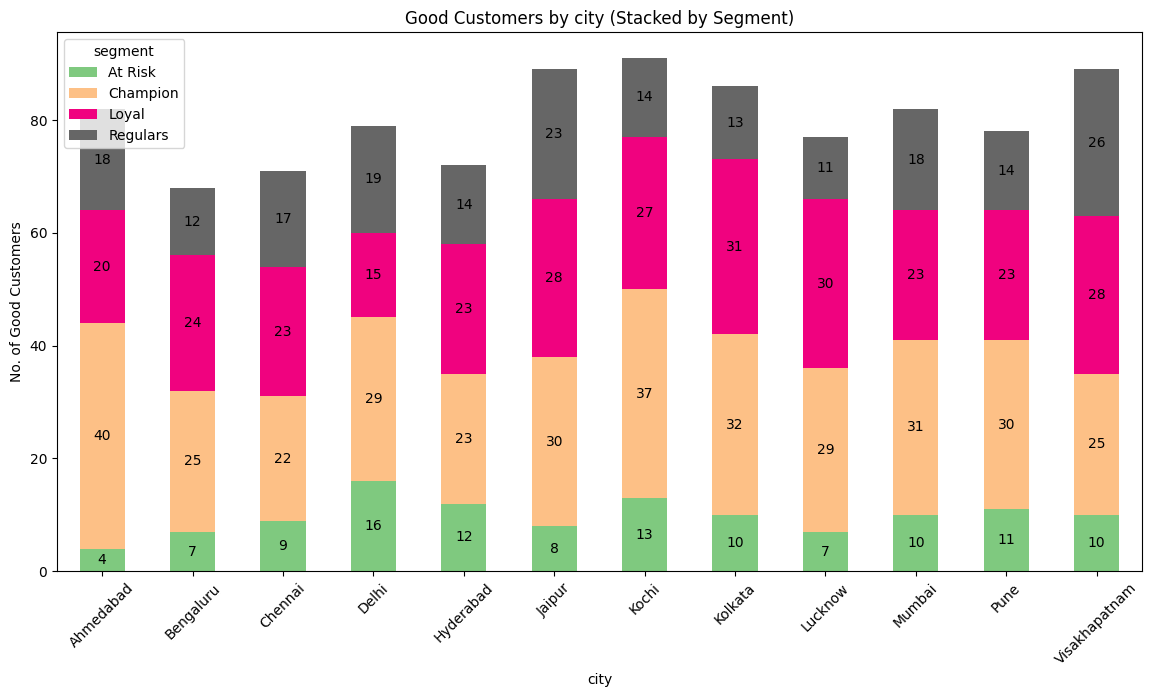

In [5]:
good_city_segment = good_customers.groupby(['city','segment'])['customer_id'].nunique().unstack(fill_value=0)

# --- City-wise ---
city_plot=good_city_segment.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    colormap="Accent"
)
plt.title("Good Customers by city (Stacked by Segment)")
plt.xlabel("city")
plt.ylabel("No. of Good Customers")
plt.xticks(rotation=45)

# Add labels inside bars
for container in city_plot.containers:
    city_plot.bar_label(container, label_type='center', fontsize=10, color='black')


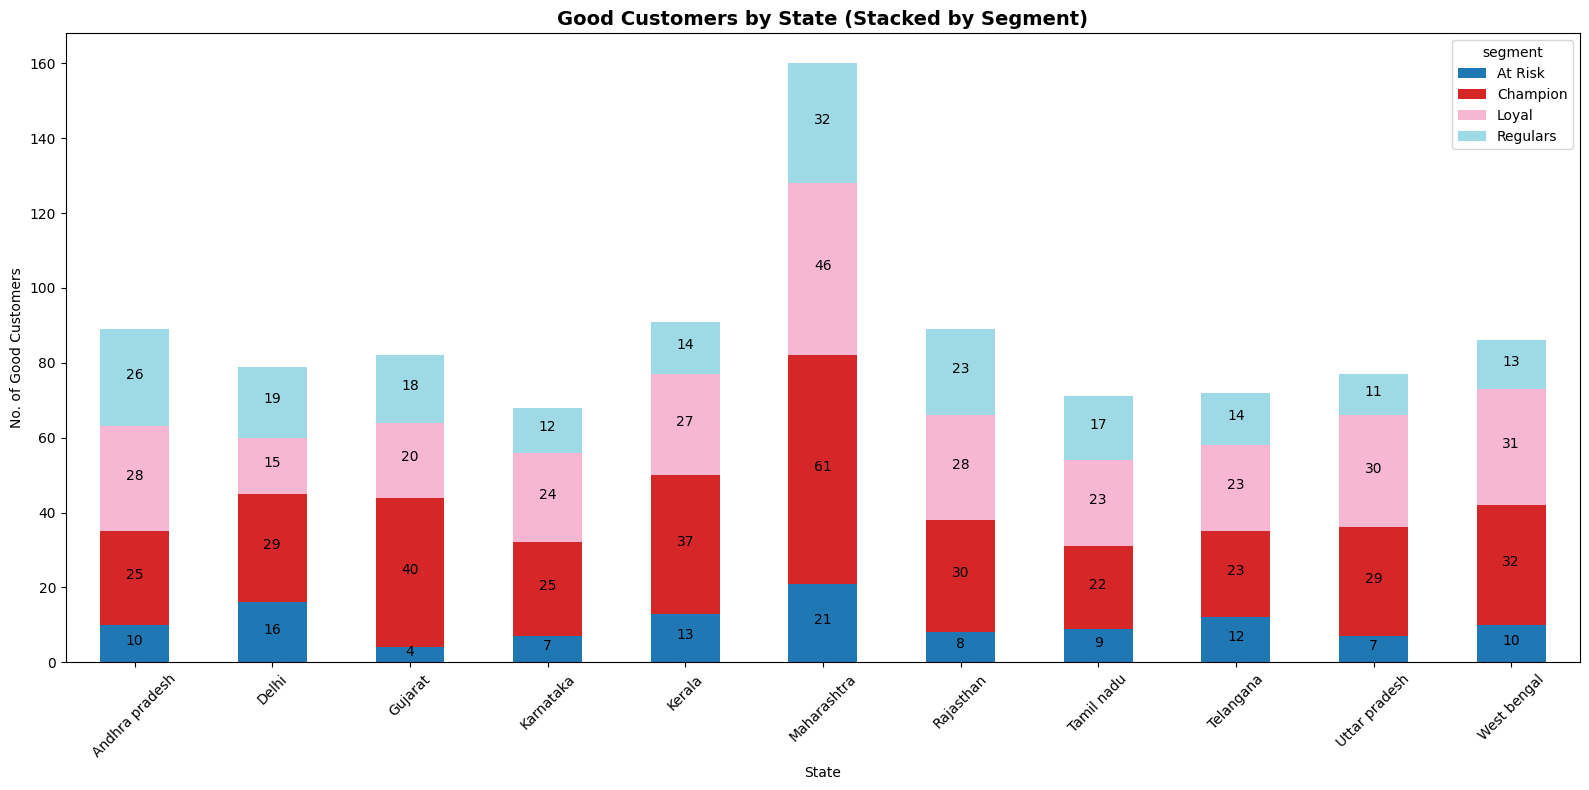

In [6]:
# State-wise stacked bar chart
good_state_segment = good_customers.groupby(['state','segment'])['customer_id'].nunique().unstack(fill_value=0)

ax = good_state_segment.plot(
    kind='bar',
    stacked=True,
    figsize=(16,8),
    colormap="tab20"  # bright colors
)

ax.set_title("Good Customers by State (Stacked by Segment)", fontsize=14, fontweight='bold')
ax.set_xlabel("State")
ax.set_ylabel("No. of Good Customers")
ax.tick_params(axis='x', rotation=45)

# --- Adjust Labels ---
for container in ax.containers:
    ax.bar_label(
        container,
        label_type='center',
        fontsize=10,
        color='black',
        padding=2   # label gap
    )

plt.tight_layout()
plt.show()


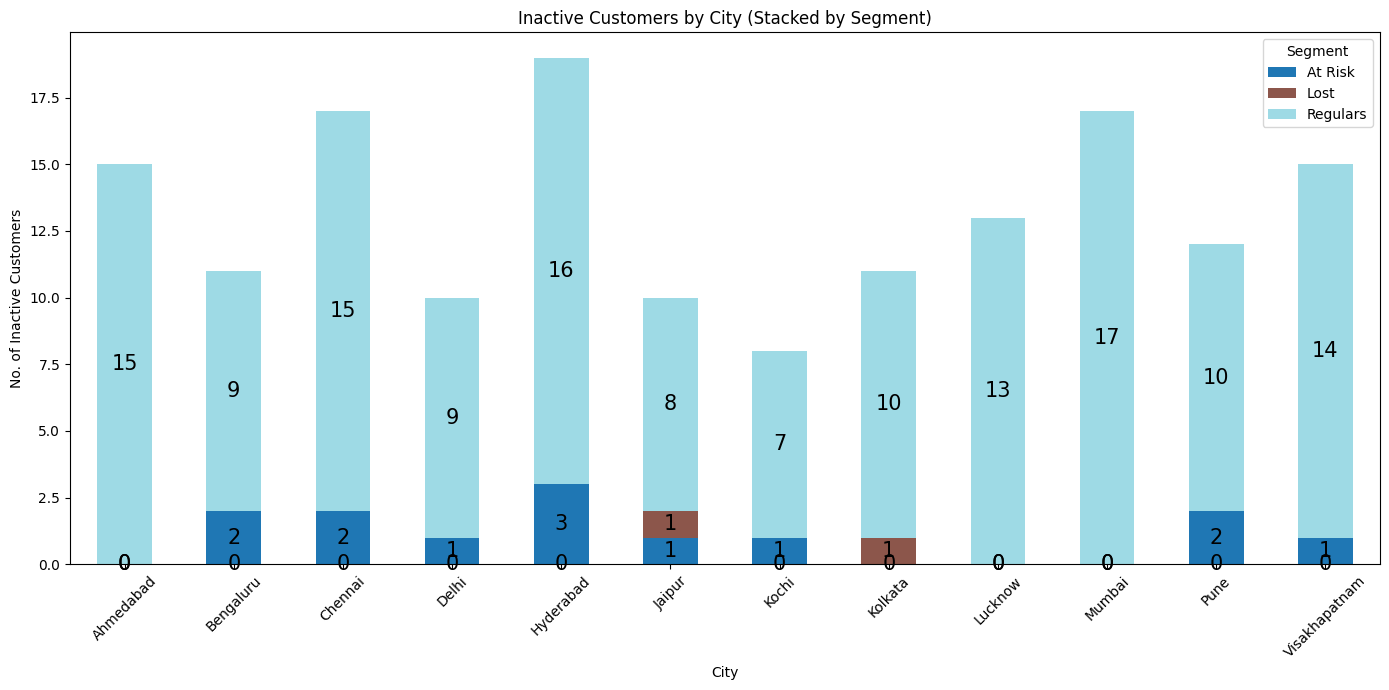

In [7]:
# Group inactive customers by city & segment
inactive_city_segment = Inactive_Customer.groupby(['city','segment'])['customer_id'].nunique().unstack(fill_value=0)

# Plot stacked bar
city_plot=inactive_city_segment.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    colormap="tab20"   # nice multi-color palette
)

plt.title("Inactive Customers by City (Stacked by Segment)")
plt.xlabel("City")
plt.ylabel("No. of Inactive Customers")
plt.xticks(rotation=45)
for container in city_plot.containers:
    city_plot.bar_label(container, label_type='center', fontsize=15, color='black')


plt.legend(title="Segment")
plt.tight_layout()
plt.show()


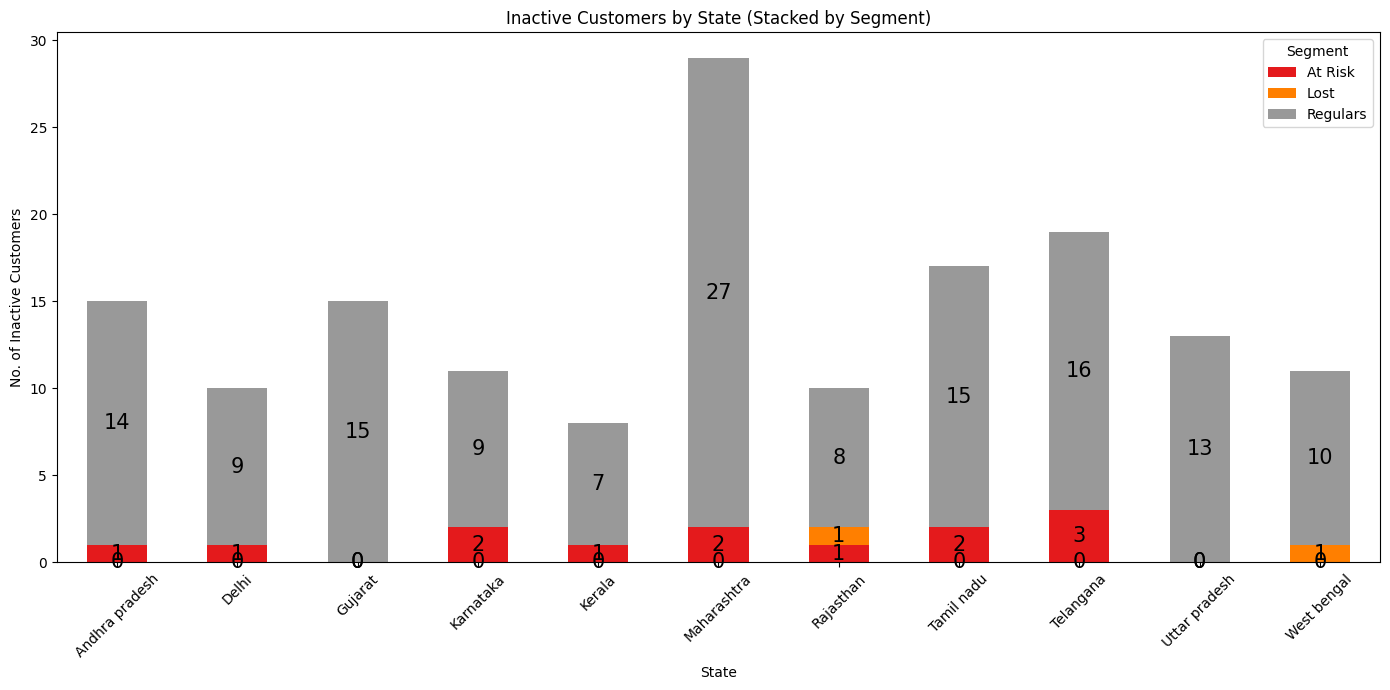

In [8]:
inactive_state_segment = Inactive_Customer.groupby(['state','segment'])['customer_id'].nunique().unstack(fill_value=0)

state_plot=inactive_state_segment.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    colormap="Set1"
)

plt.title("Inactive Customers by State (Stacked by Segment)")
plt.xlabel("State")
plt.ylabel("No. of Inactive Customers")
plt.xticks(rotation=45)
for container in state_plot.containers:
    state_plot.bar_label(container, label_type='center', fontsize=15, color='black')

plt.legend(title="Segment")
plt.tight_layout()
plt.show()


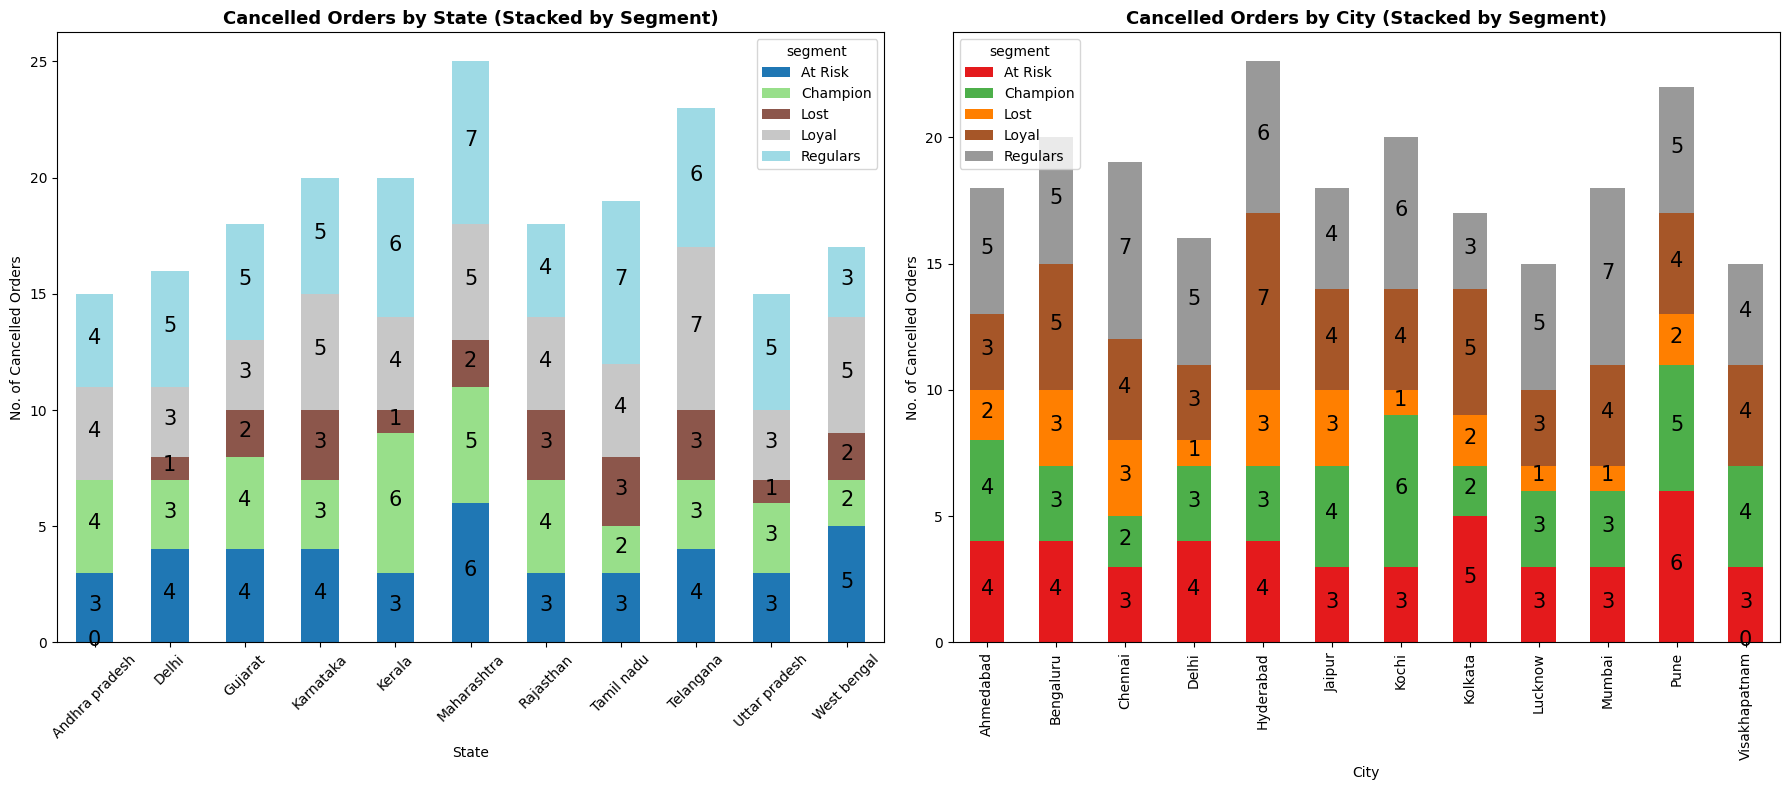

In [9]:
# Grouping Cancelled orders
cancel_state_segment = cancelled_customer.groupby(['state','segment'])['quantity'].nunique().unstack(fill_value=0)
cancel_city_segment = cancelled_customer.groupby(['city','segment'])['quantity'].nunique().unstack(fill_value=0)

# Subplot
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# ---- State-wise ----
cancel_state_segment.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    colormap="tab20"
)
axes[0].set_title("Cancelled Orders by State (Stacked by Segment)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("State")
axes[0].set_ylabel("No. of Cancelled Orders")
axes[0].tick_params(axis='x', rotation=45)

# Add labels
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='center', fontsize=15, color='black', padding=2)

# ---- City-wise ----
cancel_city_segment.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    colormap="Set1"
)
axes[1].set_title("Cancelled Orders by City (Stacked by Segment)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("City")
axes[1].set_ylabel("No. of Cancelled Orders")
axes[1].tick_params(axis='x', rotation=90)

# Add labels
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='center', fontsize=15, color='black', padding=2)

plt.tight_layout()
plt.show()


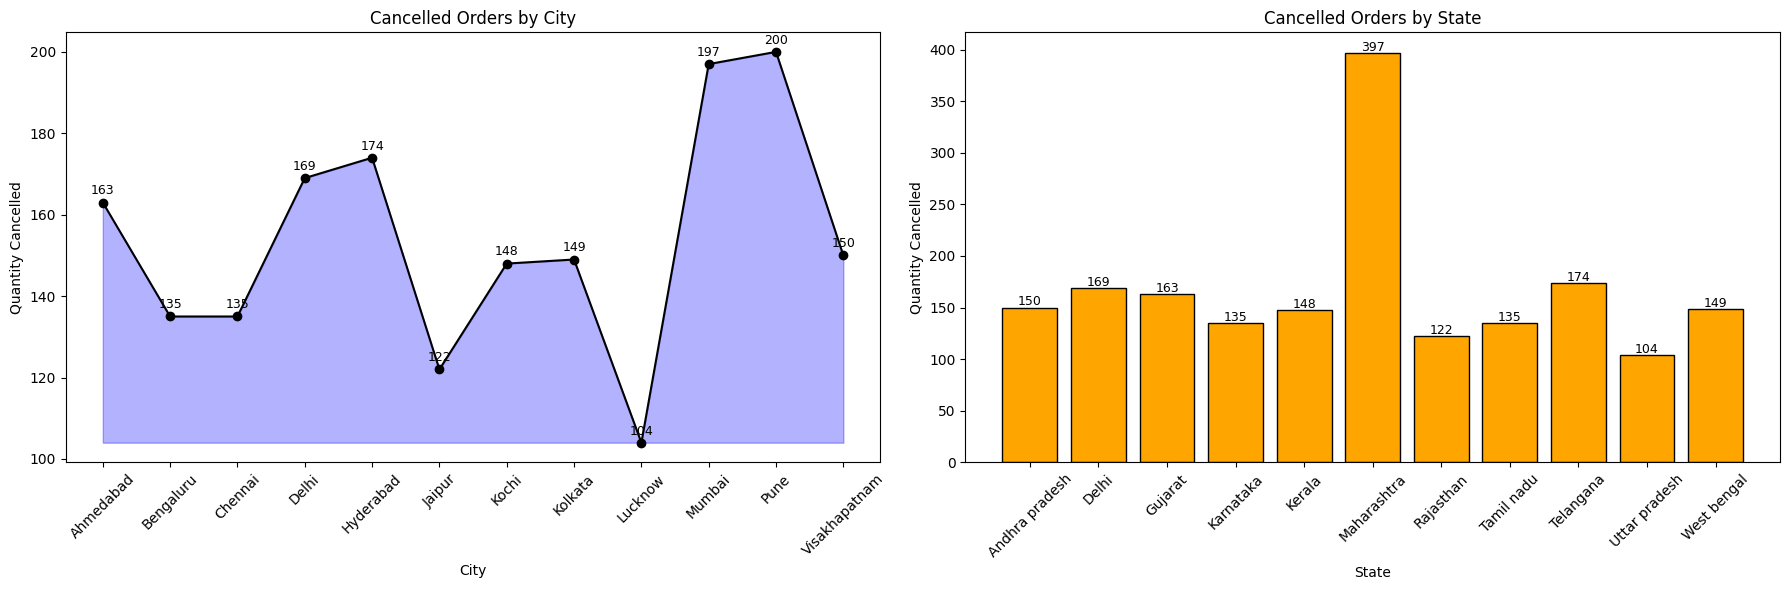

In [10]:


#  Aggregate
city_cancelled = cancelled_customer.groupby('city')['quantity'].sum()
state_cancelled = cancelled_customer.groupby('state')['quantity'].sum()

#  Subplots
fig, axes = plt.subplots(1, 2, figsize=(18,6))  # 1 row, 2 columns

# --- City Plot ---
axes[0].plot(city_cancelled.index, city_cancelled.values, 
             color='black', marker='o')
axes[0].fill_between(city_cancelled.index, city_cancelled.values, 
                     city_cancelled.values.min(), color='blue', alpha=0.3)
for i, val in enumerate(city_cancelled.values):
    axes[0].text(i, val+2, f"{val}", ha='center', fontsize=9)
axes[0].set_title("Cancelled Orders by City")
axes[0].set_xlabel("City")
axes[0].set_ylabel("Quantity Cancelled")
axes[0].tick_params(axis='x', rotation=45)

# --- State Plot ---
axes[1].bar(state_cancelled.index, state_cancelled.values, 
            color='orange', edgecolor='black')
for i, val in enumerate(state_cancelled.values):
    axes[1].text(i, val+2, f"{val}", ha='center', fontsize=9)
axes[1].set_title("Cancelled Orders by State")
axes[1].set_xlabel("State")
axes[1].set_ylabel("Quantity Cancelled")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


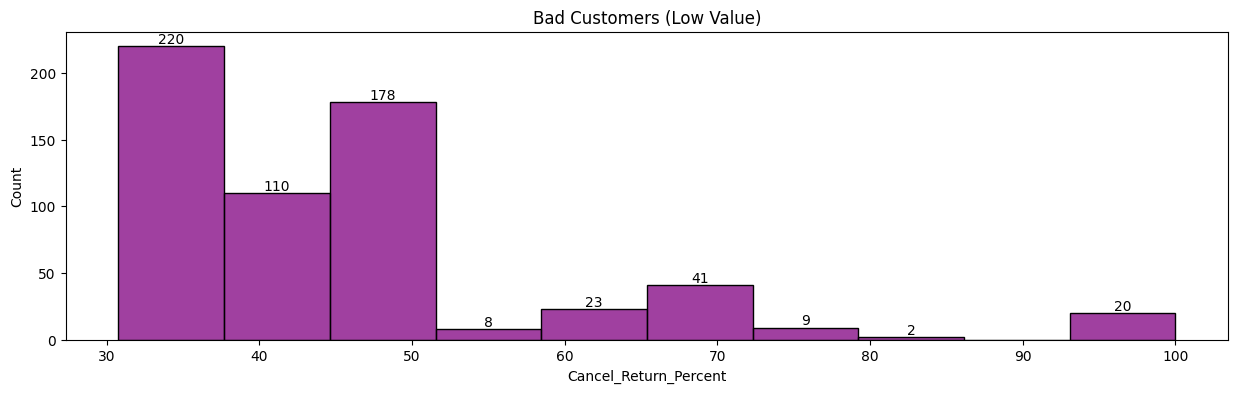

In [11]:
# Bad Customers
plt.figure(figsize=(15,4))

ax = sns.histplot(bad_customers['Cancel_Return_Percent'], bins=10, color='purple')

# Add labels on top of each bin
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # only label non-empty bins
        ax.text(
            p.get_x() + p.get_width()/2,   # x = center of bin
            height,                        # y = top of bin
            f'{int(height)}',              # label (count of customers)
            ha='center', va='bottom', fontsize=10, color='black'
        )

plt.title("Bad Customers (Low Value)")
plt.xlabel("Cancel_Return_Percent")
plt.ylabel("Count")
plt.show()


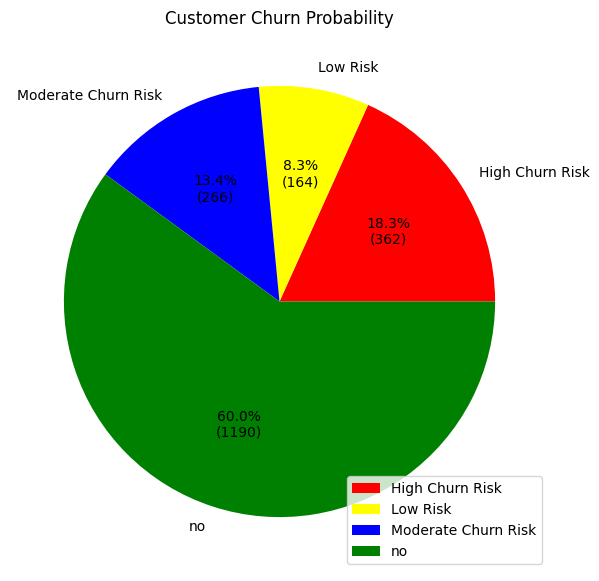

In [13]:
# Group by churn probability
counts = Churn_Probability.groupby('Churn_Probability')['customer_id'].count()


labels = counts.index
colors = ['red','yellow','blue','green']

plt.figure(figsize=(15,7))

def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct=lambda pct: func(pct, counts),
    textprops={'fontsize': 10}
)

plt.title('Customer Churn Probability')
plt.legend()
plt.show()


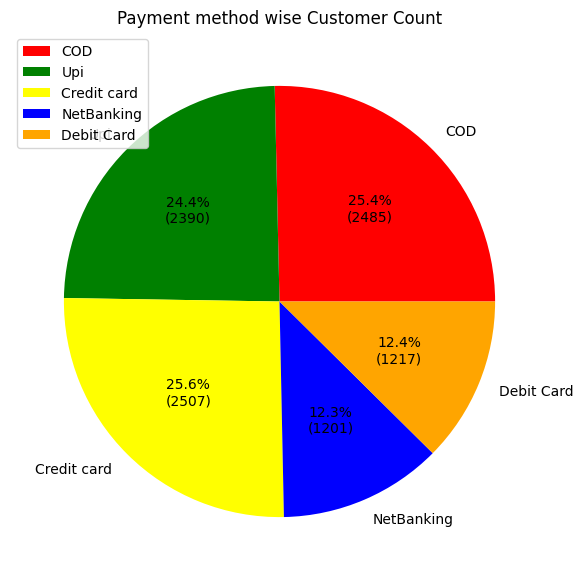

In [14]:

counts = Customer_count_method['customer_count']
labels = Customer_count_method['payment_method']
colors = ['red','green','yellow','blue','orange']

plt.figure(figsize=(15,7))

def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct=lambda pct: func(pct, counts),
    textprops={'fontsize': 10}
)

plt.title('Payment method wise Customer Count')
plt.legend()
plt.show()


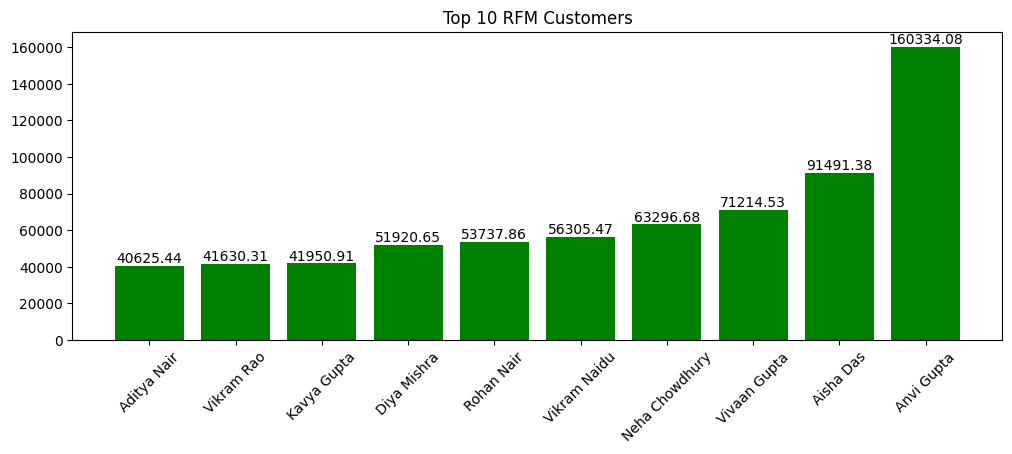

In [15]:
# Top 10 Customers
plt.figure(figsize=(12,4))
bars=plt.bar(top10_customers['full_name'], top10_customers['Monetary'].sort_values(),color='green')
for bar in bars:
   plt.text(bar.get_x() + bar.get_width()/2,       # x-position (center of bar)
             bar.get_height(),                      # y-position (top of bar)
             str(bar.get_height()),                 # label (customer count)
             ha='center', va='bottom', fontsize=10) # alignment & font size

plt.title("Top 10 RFM Customers")
plt.xticks(rotation=45)
plt.show()

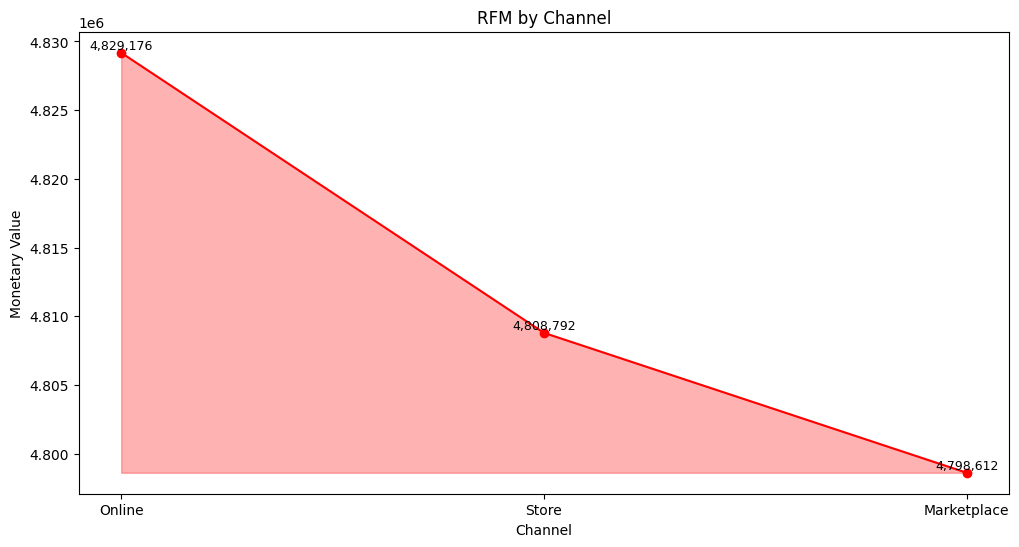

In [16]:
# RFM by Channel - Area Chart
plt.figure(figsize=(12,6))

x = rfm_by_channel['channel']
y = rfm_by_channel['Monetary']

# Plot line
plt.plot(x, y, color='red', marker='o')

# Fill area only under the curve (from min(y) to values)
plt.fill_between(x, y, y.min(), color='red', alpha=0.3)
for i, val in enumerate(y):
    plt.text(x.iloc[i], val, f"{val:,.0f}", 
             ha='center', va='bottom', fontsize=9, color='black')

plt.title("RFM by Channel")
plt.xlabel("Channel")
plt.ylabel("Monetary Value")
plt.show()


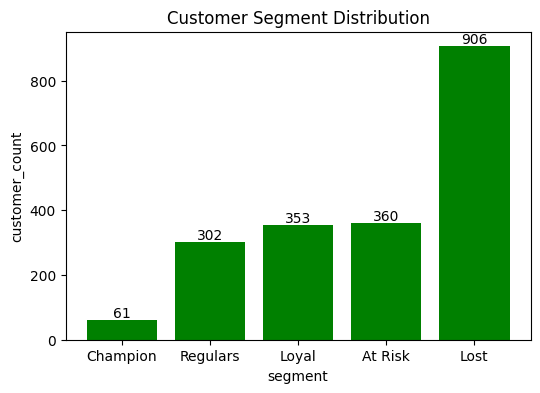

In [17]:
# Segment Distribution
plt.figure(figsize=(6,4))
bars=plt.bar(seg_distribution['segment'], seg_distribution['customer_count'].sort_values(),color='green')
for bar in bars:
   plt.text(bar.get_x() + bar.get_width()/2,         # x-position (center of bar)
             bar.get_height(),                       # y-position (top of bar)
             str(bar.get_height()),                  # label (customer count)
             ha='center', va='bottom', fontsize=10)  # alignment & font size

plt.xlabel('segment')
plt.ylabel('customer_count')
plt.title("Customer Segment Distribution")
plt.show()

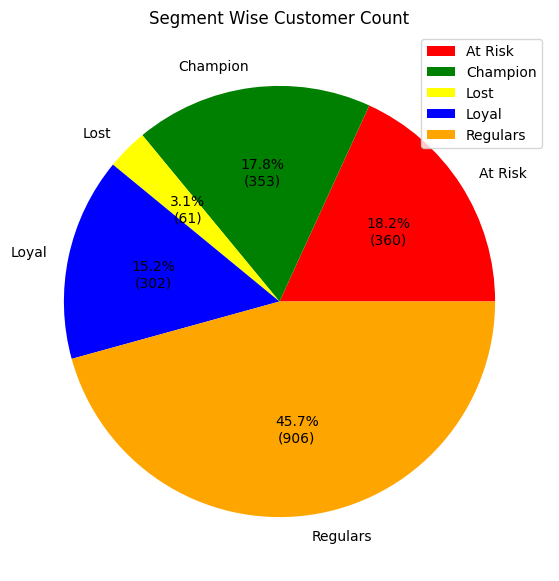

In [18]:

counts = seg_distribution.groupby('segment')['customer_count'].sum()

labels = counts.index
colors = ['red','green','yellow','blue','orange']

plt.figure(figsize=(10,7))
#plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%')
def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(counts, 
        labels=labels, 
        colors=colors, 
        autopct=lambda pct: func(pct, counts),
        textprops={'fontsize': 10})

plt.title('Segment Wise Customer Count')
plt.legend()
plt.show()


C:\Users\kanak\AppData\Local\Temp\ipykernel_2544\3623057552.py:158: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


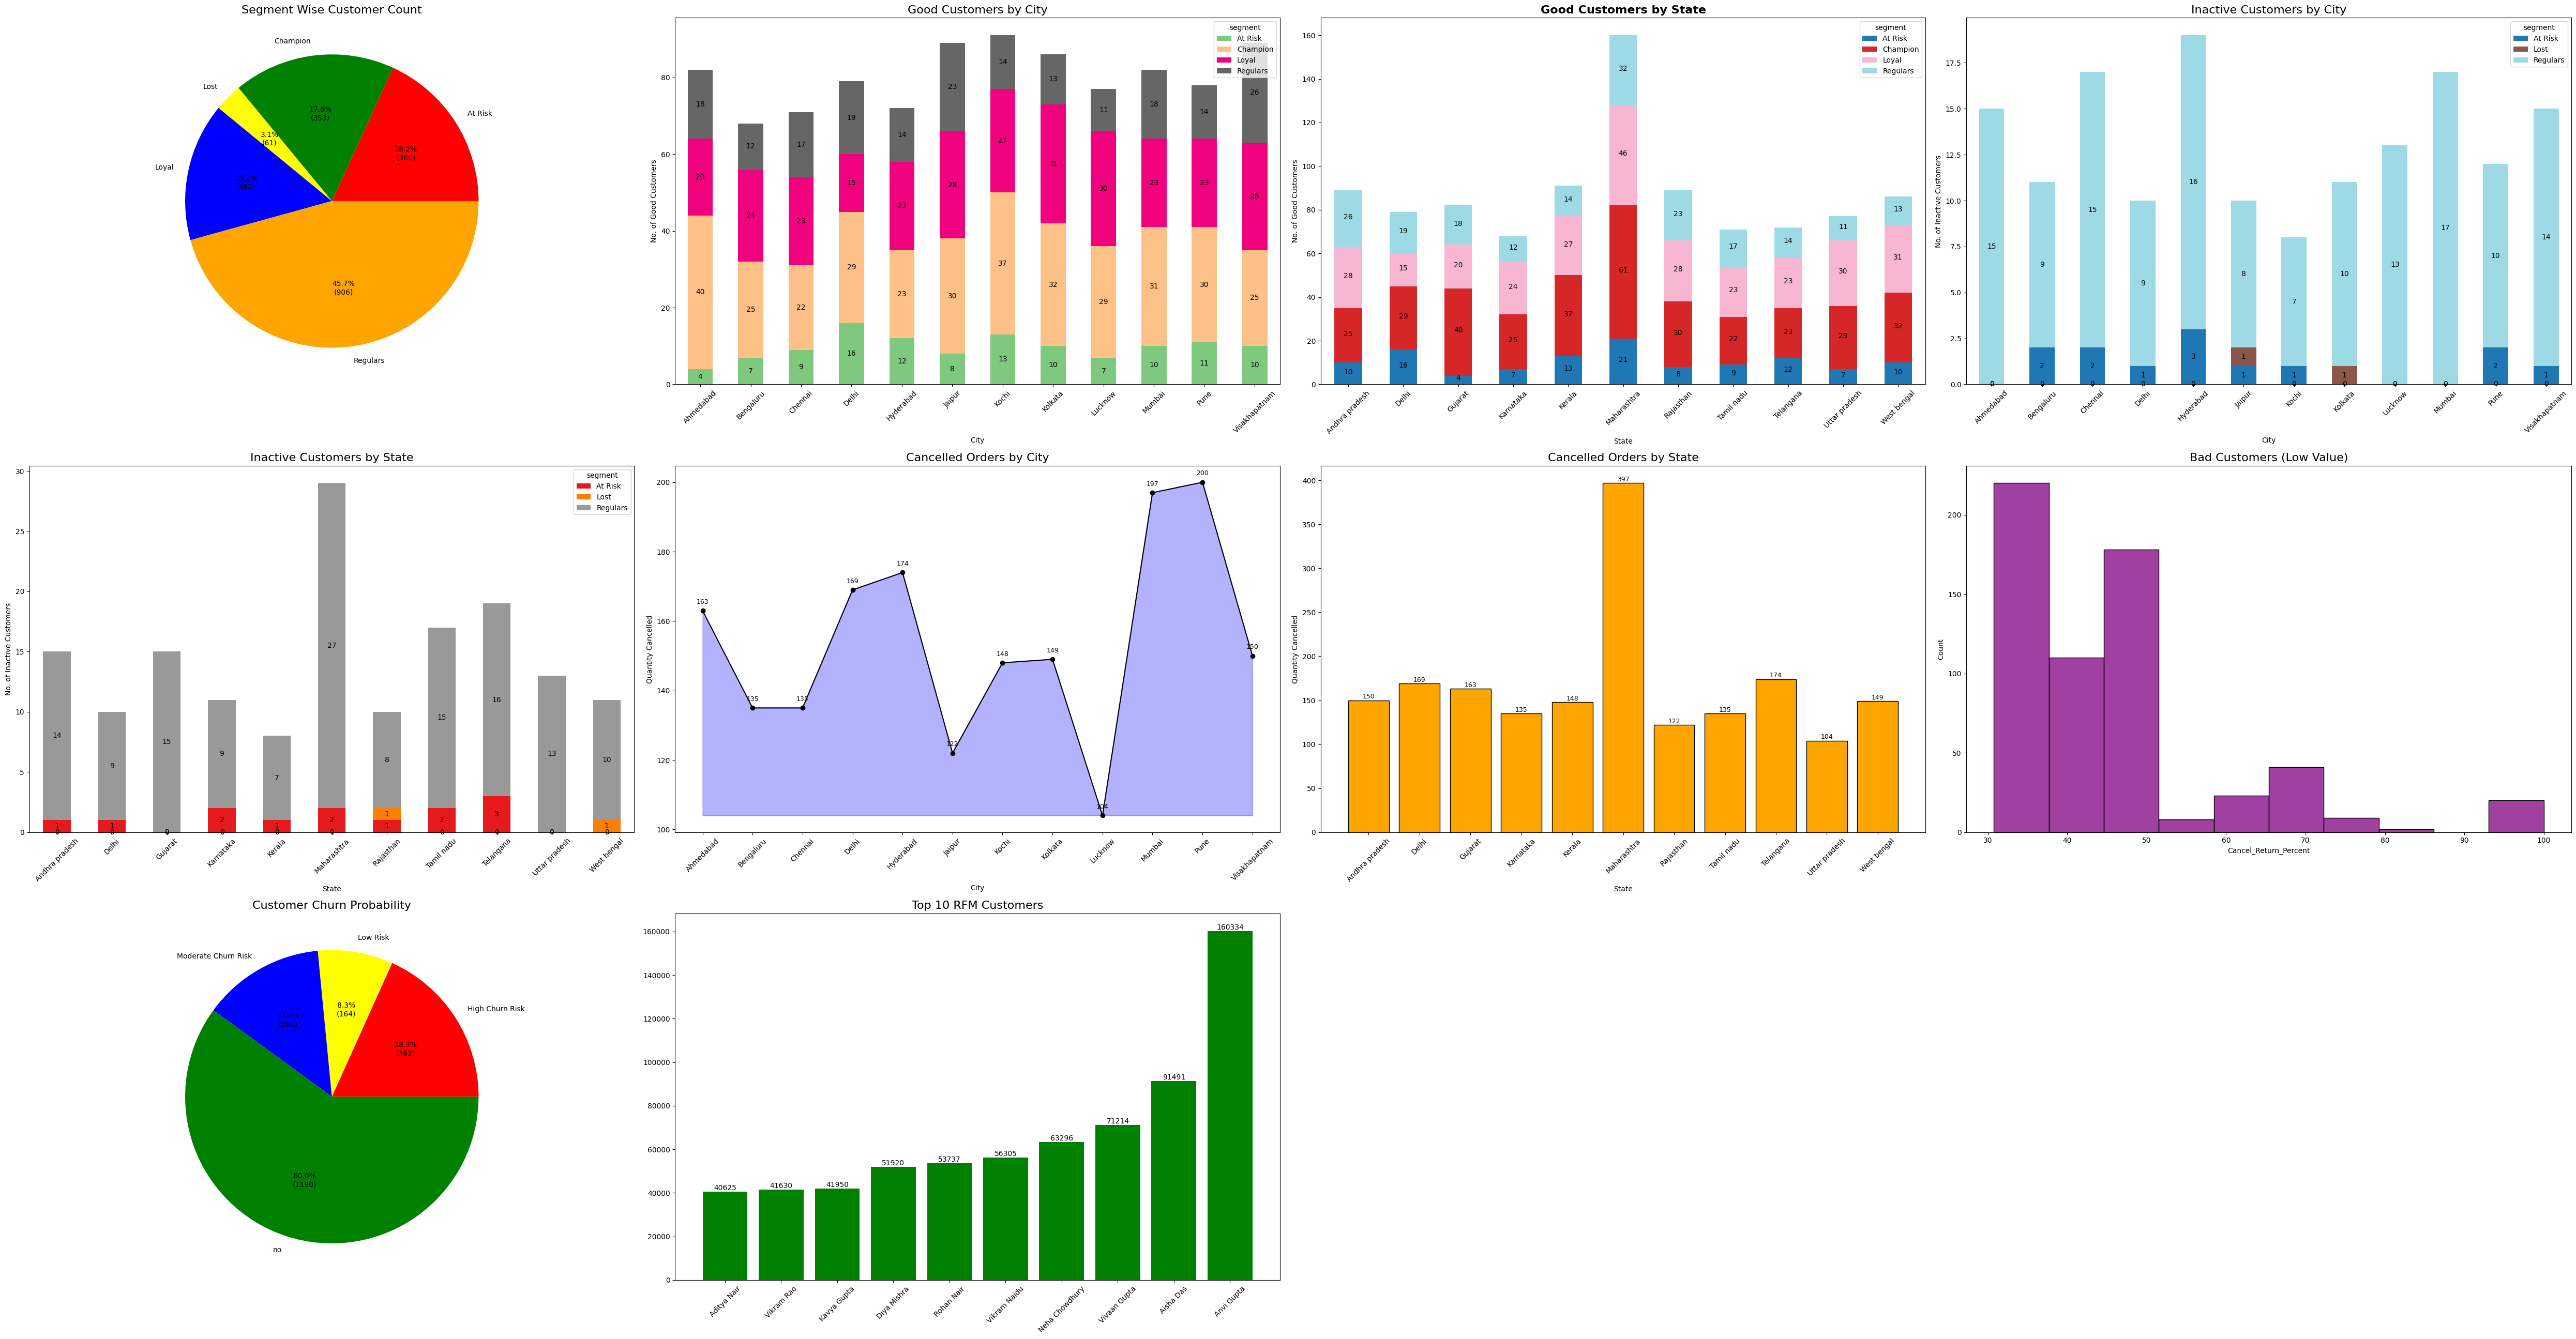

In [21]:


# Create a large dashboard figure (3 rows x 4 cols = 12 subplots)
fig = plt.figure(figsize=(50, 26), constrained_layout=True)

# ------------------------
# 1. Segment Pie
# ------------------------
ax1 = fig.add_subplot(3, 4, 1)
counts = seg_distribution.groupby('segment')['customer_count'].sum()
labels = counts.index
colors = ['red','green','yellow','blue','orange']

def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

ax1.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct=lambda pct: func(pct, counts),
    textprops={'fontsize': 10}
)
ax1.set_title("Segment Wise Customer Count", fontsize=16)


# ------------------------
# 2. Good Customers by City
# ------------------------
ax2 = fig.add_subplot(3, 4, 2)
good_city_segment = good_customers.groupby(['city','segment'])['customer_id'].nunique().unstack(fill_value=0)
good_city_segment.plot(kind='bar', stacked=True, ax=ax2, colormap="Accent")
ax2.set_title("Good Customers by City", fontsize=16)
ax2.set_xlabel("City")
ax2.set_ylabel("No. of Good Customers")
ax2.tick_params(axis='x', rotation=45)
for container in ax2.containers:
    ax2.bar_label(container, label_type='center', fontsize=10, color='black')


# ------------------------
# 3. Good Customers by State
# ------------------------
ax3 = fig.add_subplot(3, 4, 3)
good_state_segment = good_customers.groupby(['state','segment'])['customer_id'].nunique().unstack(fill_value=0)
good_state_segment.plot(kind='bar', stacked=True, ax=ax3, colormap="tab20")
ax3.set_title("Good Customers by State", fontsize=16, fontweight='bold')
ax3.set_xlabel("State")
ax3.set_ylabel("No. of Good Customers")
ax3.tick_params(axis='x', rotation=45)
for container in ax3.containers:
    ax3.bar_label(container, label_type='center', fontsize=10, color='black', padding=2)


# ------------------------
# 4. Inactive Customers by City
# ------------------------
ax4 = fig.add_subplot(3, 4, 4)
inactive_city_segment = Inactive_Customer.groupby(['city','segment'])['customer_id'].nunique().unstack(fill_value=0)
inactive_city_segment.plot(kind='bar', stacked=True, ax=ax4, colormap="tab20")
ax4.set_title("Inactive Customers by City", fontsize=16)
ax4.set_xlabel("City")
ax4.set_ylabel("No. of Inactive Customers")
ax4.tick_params(axis='x', rotation=45)
for container in ax4.containers:
    ax4.bar_label(container, label_type='center', fontsize=10, color='black')


# ------------------------
# 5. Inactive Customers by State
# ------------------------
ax5 = fig.add_subplot(3, 4, 5)
inactive_state_segment = Inactive_Customer.groupby(['state','segment'])['customer_id'].nunique().unstack(fill_value=0)
inactive_state_segment.plot(kind='bar', stacked=True, ax=ax5, colormap="Set1")
ax5.set_title("Inactive Customers by State", fontsize=16)
ax5.set_xlabel("State")
ax5.set_ylabel("No. of Inactive Customers")
ax5.tick_params(axis='x', rotation=45)
for container in ax5.containers:
    ax5.bar_label(container, label_type='center', fontsize=10, color='black')


# ------------------------
# 6. Cancelled Orders by City
# ------------------------
ax6 = fig.add_subplot(3, 4, 6)
city_cancelled = cancelled_customer.groupby('city')['quantity'].sum()
ax6.plot(city_cancelled.index, city_cancelled.values, color='black', marker='o')
ax6.fill_between(city_cancelled.index, city_cancelled.values, city_cancelled.values.min(), color='blue', alpha=0.3)
for i, val in enumerate(city_cancelled.values):
    ax6.text(i, val+2, f"{val}", ha='center', fontsize=9)
ax6.set_title("Cancelled Orders by City", fontsize=16)
ax6.set_xlabel("City")
ax6.set_ylabel("Quantity Cancelled")
ax6.tick_params(axis='x', rotation=45)


# ------------------------
# 7. Cancelled Orders by State
# ------------------------
ax7 = fig.add_subplot(3, 4, 7)
state_cancelled = cancelled_customer.groupby('state')['quantity'].sum()
ax7.bar(state_cancelled.index, state_cancelled.values, color='orange', edgecolor='black')
for i, val in enumerate(state_cancelled.values):
    ax7.text(i, val+2, f"{val}", ha='center', fontsize=9)
ax7.set_title("Cancelled Orders by State", fontsize=16)
ax7.set_xlabel("State")
ax7.set_ylabel("Quantity Cancelled")
ax7.tick_params(axis='x', rotation=45)


# ------------------------
# 8. Bad Customers Histogram
# ------------------------
ax8 = fig.add_subplot(3, 4, 8)
sns.histplot(bad_customers['Cancel_Return_Percent'], bins=10, color='purple', ax=ax8)
ax8.set_title("Bad Customers (Low Value)", fontsize=16)
ax8.set_xlabel("Cancel_Return_Percent")
ax8.set_ylabel("Count")


# ------------------------
# 9. Churn Probability Pie
# ------------------------
ax9 = fig.add_subplot(3, 4, 9)
counts = Churn_Probability.groupby('Churn_Probability')['customer_id'].count()
ax9.pie(
    counts.values,
    labels=counts.index,
    colors=['red','yellow','blue','green'],
    autopct=lambda pct: func(pct, counts.values),
    textprops={'fontsize': 10}
)
ax9.set_title("Customer Churn Probability", fontsize=16)


# ------------------------
# 10. Top 10 RFM Customers
# ------------------------
ax10 = fig.add_subplot(3, 4, 10)
bars = ax10.bar(
    top10_customers['full_name'],
    top10_customers['Monetary'].sort_values(),
    color='green'
)
for bar in bars:
    ax10.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(int(bar.get_height())),
        ha='center', va='bottom', fontsize=10
    )
ax10.set_title("Top 10 RFM Customers", fontsize=16)
ax10.tick_params(axis='x', rotation=45)

# ------------------------
# Show dashboard
# ------------------------
plt.tight_layout()
plt.show()


### THE END
